In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [4]:
BTC_BUSD = pd.read_parquet("Data/BTC-BUSD.parquet")
BTC_BUSD.head(15)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688,0.001113,10.998032,1,0.001113,10.998032
2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352,0.012940,127.825981,1,0.012940,127.825981
2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:07:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:08:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:09:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000
2019-09-19 10:10:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000


In [5]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

In [6]:
# Data clean and related analysis
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=False, inplace=True)

Text(0, 0.5, 'BTC-BUSD')

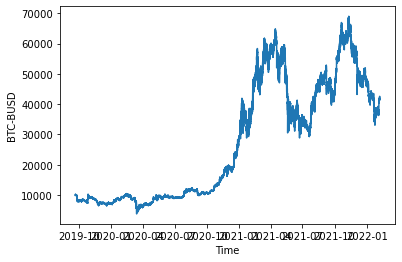

In [7]:
plt.plot(BTC_BUSD_copy['open_time'], BTC_BUSD_copy['open'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD')

In [8]:
# Option1: use price 5 minutes later
# Set target predict price (5 minutes later)
target_price = BTC_BUSD_copy['open'].shift(-5, fill_value=BTC_BUSD['open'][-1]).rename("price_5_min_later")
target_price

0           9878.360352
1           9878.360352
2           9878.360352
3           9878.360352
4           9878.360352
               ...     
1252557    42416.441406
1252558    42416.441406
1252559    42416.441406
1252560    42416.441406
1252561    42416.441406
Name: price_5_min_later, Length: 1252562, dtype: float32

In [9]:
# Option2 : use window sliding mean
window = 5
open_price = list(BTC_BUSD_copy['open'].values)
open_price = open_price + [open_price[-1]] * (window - 1)
print(len(open_price))
target_price = pd.Series(np.convolve(open_price, np.ones(window), mode='valid') / window,  name='mean_price_in_future_5_minutes')
target_price

1252566


0           9879.588086
1           9878.974219
2           9878.360352
3           9878.360352
4           9878.360352
               ...     
1252557    42420.134375
1252558    42414.886719
1252559    42419.060937
1252560    42420.392969
1252561    42416.441406
Name: mean_price_in_future_5_minutes, Length: 1252562, dtype: float64

In [10]:
# plt.plot(BTC_BUSD_copy['open'],'b')
# plt.plot(target_price, 'r')

In [11]:
dataset = pd.concat([BTC_BUSD_copy, target_price], axis=1)
dataset.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,mean_price_in_future_5_minutes
0,2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688,0.001113,10.998032,1,0.001113,10.998032,9879.588086
1,2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688,0.000000,0.000000,0,0.000000,0.000000,9878.974219
2,2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352,0.012940,127.825981,1,0.012940,127.825981,9878.360352
3,2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352
4,2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352


In [12]:
class GBDT_model():
    def __init__(self, **kwargs):
        self.loss = kwargs.get('loss', 'ls')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 2)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.max_leaf_nodes = kwargs.get('max_leaf_nodes', None)
        self.min_samples_leaf = kwargs.get('min_samples_leaf', 3)
        self.min_samples_split = kwargs.get('min_samples_split', 5)
        self.alpha = kwargs.get('alpha', 0.9)
# param_space = {
#     'n_estimators': [range(50,100,10)],
#     'max_depth': [range(5,10)],
#     '': [10,20,30,40,50,60],
#     ''
#
# }

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                              subsample=self.subsample, max_depth=self.max_depth,
                                              n_estimators=self.n_estimators,
                                              max_leaf_nodes=self.max_leaf_nodes,
                                              min_samples_leaf=self.min_samples_leaf,
                                              min_samples_split=self.min_samples_split,
                                              alpha=self.alpha)
        gbdt = GridSearchCV(estimator=estimator, 
                            param_grid=param_space, 
                            cv=KFold(n_splits=num_sets, shuffle=True), 
                            scoring='neg_mean_absolute_error')
        grid_result = gbdt.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']

        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = gbdt.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.max_leaf_nodes = best_params.get('max_leaf_nodes', self.max_leaf_nodes)
        self.min_samples_leaf = best_params.get('min_samples_leaf', self.min_samples_leaf)
        self.min_samples_split = best_params.get('min_samples_split', self.min_samples_split)
        self.alpha = best_params.get('alpha', self.alpha)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.max_leaf_nodes = params.get('max_leaf_nodes', self.max_leaf_nodes)
            self.min_samples_leaf = params.get('min_samples_leaf', self.min_samples_leaf)
            self.min_samples_split = params.get('min_samples_split', self.min_samples_split)
            self.alpha = params.get('alpha', self.alpha)

        gbdt = GradientBoostingRegressor(loss=self.loss, learning_rate=self.learning_rate,
                                         subsample=self.subsample, max_depth=self.max_depth,
                                         n_estimators=self.n_estimators,
                                         max_leaf_nodes=self.max_leaf_nodes,
                                         min_samples_leaf=self.min_samples_leaf,
                                         min_samples_split=self.min_samples_split, alpha=self.alpha)
        # 10折交叉验证
        sk = KFold(n_splits=10, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            gbdt.fit(train_x, train_y)
            pred_train_gbdt = gbdt.predict(train_x)
            pred_val_gbdt = gbdt.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_gbdt)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_gbdt)
            scores_val.append(score_val)

        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))

        return gbdt

    @staticmethod
    def save_model(model):

        print('Saving model...')
        folder_path = os.getcwd()
        model_path = folder_path + '\\gbdt_model.pkl'
        joblib.dump(model, model_path)
        print('Model saved.')

    @staticmethod
    def predict_with_model(model, x_test):
        y_test_pred = model.predict(x_test)

        return y_test_pred




In [13]:
N = len(dataset)

# Set starting point & train length
start_point = int(0.2*N)
train_length = 15 * 24 * 60
# Set test length
test_length = 24 * 60

X_train = dataset.iloc[start_point : start_point + train_length, 1:-1]
Y_train = dataset.iloc[start_point : start_point + train_length, -1]

X_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length , 1:-1]
Y_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length , -1]

print("Train range: ", start_point, " - ", start_point + train_length)
print("Train length:", train_length)
print('='*20)
print("Test range: ", start_point + train_length, " - ", start_point + train_length + test_length)
print("Test length:", test_length)

Train range:  250512  -  272112
Train length: 21600
Test range:  272112  -  273552
Test length: 1440


In [14]:
# With hyperparameter grid search

task = GBDT_model()

params = {'learning_rate': [0.1, 0.3],
          'max_depth': [1,2,3],
          'n_estimators': [100]

}


gbdt_reg = task.build_model(X_train, Y_train, params, grid_search=True)
# mymodel.save_model(gbdt_reg)
Y_test_pred = task.predict_with_model(gbdt_reg, X_test)
print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

Finding best hyper-parameters for the model...
-20.388626  with:   {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
-12.123450  with:   {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
-9.884591  with:   {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
-35.803993  with:   {'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 100}
-13.856985  with:   {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
-10.538055  with:   {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Best params set: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Minimum mean absolute error: 9.88459115608407
---------------------------------------------------
Train mean absolute error: 8.906416508865945
Val mean absolute error: 9.816941397516477
Test mean absolute error: 4.815769


In [156]:
# Without hyperparameter grid search

task = GBDT_model()

params = {'learning_rate': 0.1, 'n_estimators': 150

}

gbdt_reg = task.build_model(X_train, Y_train, params, grid_search=False)
# mymodel.save_model(gbdt_reg)
Y_test_pred = task.predict_with_model(gbdt_reg, X_test)
print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

Train mean absolute error: 10.400229581535418
Val mean absolute error: 11.030855249513994
Test mean absolute error: 352.293225


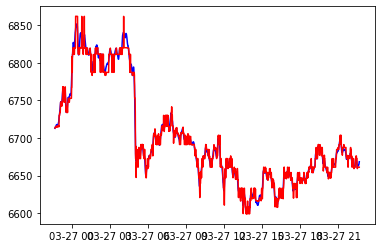

In [15]:
# When the start point is int(0.2*N), the model works well
# plt.plot(dataset['open_time'][start_point : start_point + train_length], Y_train, 'g')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test, 'b')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test_pred, 'r')

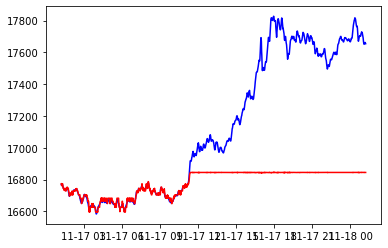

In [158]:
# When the start point is int(0.47*N), the model cannot handle unseen large values
# plt.plot(dataset['open_time'][start_point : start_point + train_length], Y_train, 'g')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test, 'b')
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], Y_test_pred, 'r')